In [1]:
import os
import yaml
from argparse import Namespace
from pprint import pprint
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from corner import corner
from astropy.coordinates import SkyCoord
import astropy.units as u
from speclite import filters
import pickle
from scipy.stats import poisson
import warnings
from tqdm.auto import tqdm as tqdm_auto

from mejiro.style import set_aas_style
from mejiro.utils import util
from mejiro.utils.pipeline_helper import PipelineHelper
from mejiro.instruments.roman import Roman
from mejiro.engines.galsim_engine import GalSimEngine
from mejiro.exposure import Exposure

set_aas_style()

# read configuration file
import mejiro
config_file = 'nancy.yaml'
with open(config_file, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

config['dev'] = True
if config['dev']:
    config['pipeline_label'] += '_dev'

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/speclite/resample.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkgr


In [2]:
args = Namespace(config='nancy.yaml')
pipeline = PipelineHelper(args, '04', 'nancy', ['roman'])

if config['dev']:
    pipeline.input_dir = '/nfsdata1/bwedig/mejiro/nancy_dev/04'
input_pickles = pipeline.retrieve_roman_pickles(prefix='SyntheticImage', suffix='', extension='.pkl')
print(f'Found {len(input_pickles)} input pickle(s).')

Found 612 input pickle(s).


In [3]:
dev = False

Number of pixels: 7500


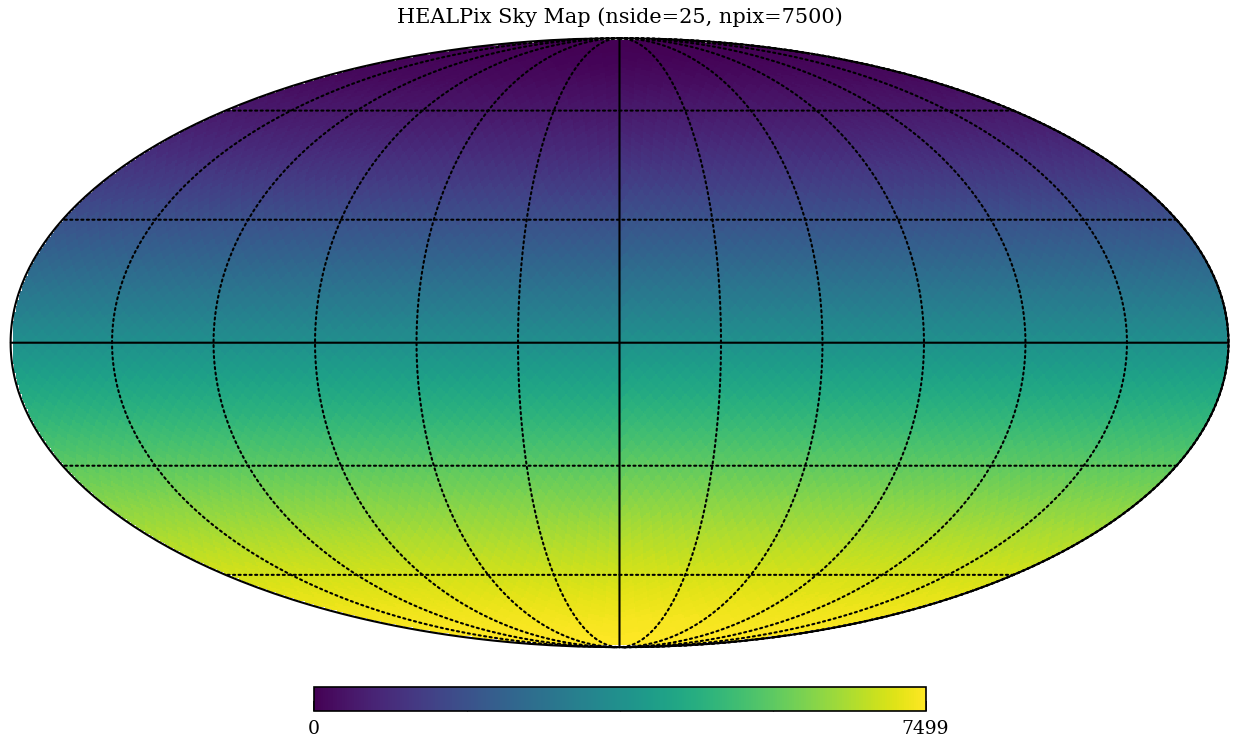

Area per pixel: 5.50 sq deg
Total sky area: 41252.96 sq deg


In [4]:
# HEALPix uses nside parameter where npix = 12 * nside^2
if dev:
    nside = 5
else:
    nside = 25
npix = hp.nside2npix(nside)
print(f"Number of pixels: {npix}")

# HEALPix by default uses Galactic coordinates
# theta = colatitude from north galactic pole, phi = galactic longitude
theta, phi = hp.pix2ang(nside, np.arange(npix))

# Convert to Galactic l, b
l = np.rad2deg(phi)           # Galactic longitude [0, 360]
b = 90 - np.rad2deg(theta)    # Galactic latitude [-90, 90]

# Create SkyCoord in Galactic frame
coords_gal = SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic')

# Create a map (e.g., with pixel indices as values)
sky_map = np.arange(npix)

# Plot the map
hp.mollview(sky_map, title=f"HEALPix Sky Map (nside={nside}, npix={npix})", cmap='viridis')
hp.graticule()

# Overplot the pixel centers
# hp.projscatter(theta, phi, marker='o', color='red', s=20)

plt.show()

# Get the area of each pixel in square degrees
pixel_area = hp.nside2pixarea(nside, degrees=True)
print(f"Area per pixel: {pixel_area:.2f} sq deg")
print(f"Total sky area: {npix * pixel_area:.2f} sq deg")

In [5]:
if dev:
    bkg_pkl_file = 'bkg_dev.pkl'
else:
    bkg_pkl_file = 'bkg.pkl'

with open(bkg_pkl_file, 'rb') as f:
    bkg_dict = pickle.load(f)

In [6]:
bkg_array = np.array([bkg_dict[i][111] for i in range(npix)])

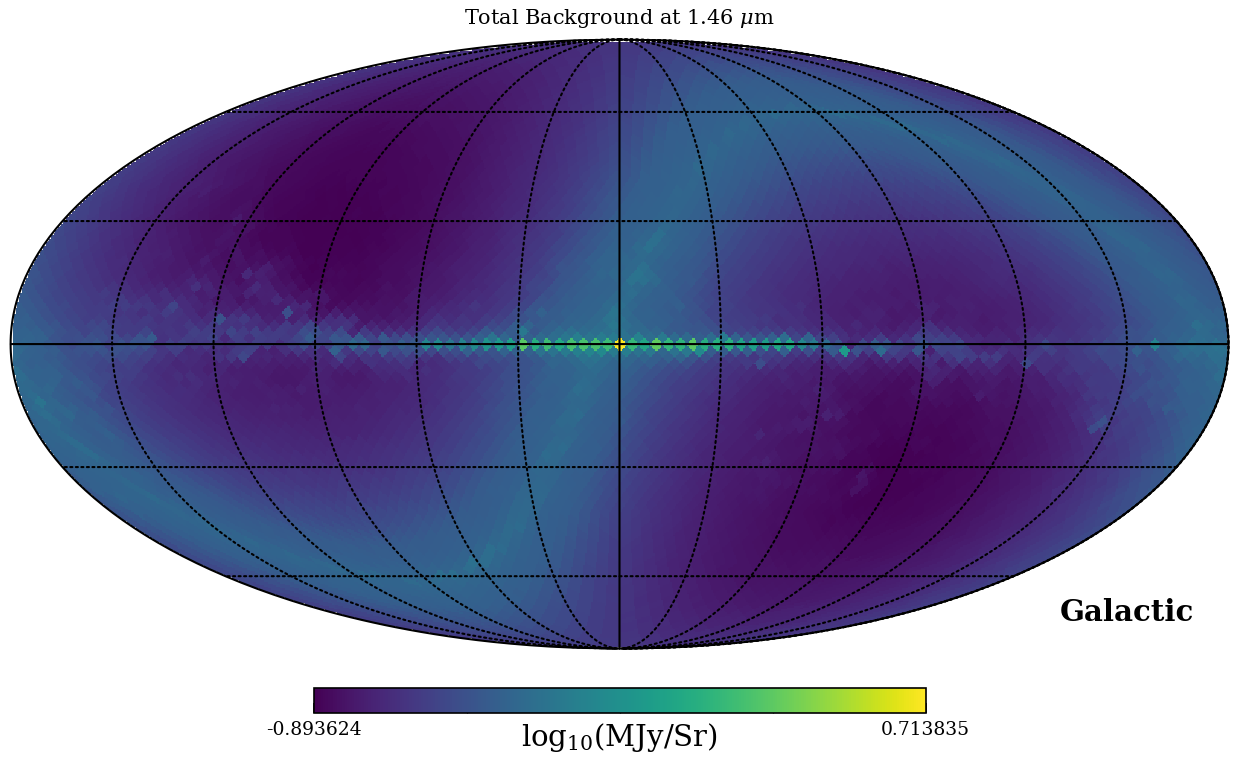

In [7]:
hp.mollview(np.log10(bkg_array), 
            title=r"Total Background at 1.46 $\mu$m", 
            cmap='viridis', coord='G', unit=r'$\log_{10}$(MJy/Sr)')
hp.graticule()
plt.savefig('total_bkg.png', dpi=300)
plt.show()

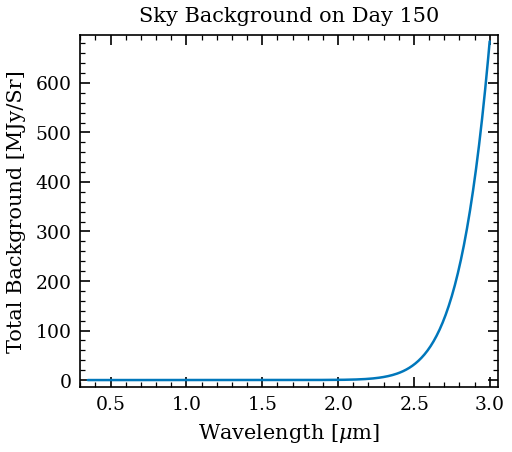

In [8]:
plt.figure(figsize=(3.4, 3))
plt.plot(bkg_dict['wave_array'], bkg_dict[150])
plt.title('Sky Background on Day 150')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel('Total Background [MJy/Sr]')
plt.show()

```python
# Detailed visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Main title
fig.suptitle(f'Spectrum → Counts/sec Conversion Pipeline for Roman {filter_name}', 
             fontsize=15, fontweight='bold', y=0.98)

# Panel 1: Input spectrum (MJy/sr)
ax1 = fig.add_subplot(gs[0, 0])
ax1.semilogy(wavelength_microns, flux_mjy_per_sr, 'b-', linewidth=2.5, label='Input spectrum')
ax1.set_xlabel('Wavelength (μm)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Surface Brightness (MJy/sr)', fontsize=11, fontweight='bold')
ax1.set_title('Step 1: Input Spectrum', fontsize=12, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=10, framealpha=0.9)
ax1.set_xlim(0.5, 5.0)

# Panel 2: Flux per pixel
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(wavelength_microns, flux_mjy_per_pixel, 'g-', linewidth=2.5, 
             label=f'Flux per pixel')
ax2.set_xlabel('Wavelength (μm)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Flux Density (MJy/pixel)', fontsize=11, fontweight='bold')
ax2.set_title(f'Step 2: × Pixel Solid Angle\n({pixel_solid_angle_sr:.3e} sr)', 
              fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=10, framealpha=0.9)
ax2.set_xlim(0.5, 5.0)

# Panel 3: Filter response
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(filter_wavelength/1e4, filter_transmission, 'r-', linewidth=2.5, 
         label=f'{filter_name}')
ax3.fill_between(filter_wavelength/1e4, 0, filter_transmission, alpha=0.3, color='red')
ax3.set_xlabel('Wavelength (μm)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Transmission', fontsize=11, fontweight='bold')
ax3.set_title('Filter Response Curve', fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(fontsize=10, framealpha=0.9)
ax3.set_xlim(0.5, 5.0)
ax3.set_ylim(0, 1.1*np.max(filter_transmission))

# Panel 4: Energy flux f_λ
ax4 = fig.add_subplot(gs[1, 0])
ax4.semilogy(wavelength_angstrom, flux_lambda_erg, 'purple', linewidth=2.5, 
             label=r'Energy flux $f_\lambda$')
ax4.set_xlabel('Wavelength (Å)', fontsize=11, fontweight='bold')
ax4.set_ylabel(r'$f_\lambda$ (erg/s/cm²/Å)', fontsize=11, fontweight='bold')
ax4.set_title(r'Step 3: Convert to $f_\lambda$ (energy flux)', 
              fontsize=12, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.legend(fontsize=10, framealpha=0.9)

# Panel 5: Photon flux
ax5 = fig.add_subplot(gs[1, 1])
ax5.semilogy(wavelength_angstrom, photon_flux, 'orange', linewidth=2.5, 
             label='Photon flux')
ax5.set_xlabel('Wavelength (Å)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Photon Flux\n(photons/s/cm²/Å)', fontsize=11, fontweight='bold')
ax5.set_title(r'Step 4: Convert to Photons ($÷ h\nu$)', 
              fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3, linestyle='--')
ax5.legend(fontsize=10, framealpha=0.9)

# Panel 6: Overlay photon flux and filter
ax6 = fig.add_subplot(gs[1, 2])
ax6_twin = ax6.twinx()
ax6.semilogy(wavelength_angstrom, photon_flux, 'orange', linewidth=2.5, 
             label='Photon flux', alpha=0.7)
ax6_twin.plot(filter_wavelength, filter_transmission, 'r-', linewidth=2.5, 
              label=f'{filter_name}', alpha=0.7)
ax6_twin.fill_between(filter_wavelength, 0, filter_transmission, alpha=0.2, color='red')
ax6.set_xlabel('Wavelength (Å)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Photon Flux\n(photons/s/cm²/Å)', fontsize=11, fontweight='bold', color='orange')
ax6_twin.set_ylabel('Transmission', fontsize=11, fontweight='bold', color='red')
ax6.set_title('Step 5: Align Spectrum & Filter', fontsize=12, fontweight='bold', pad=10)
ax6.tick_params(axis='y', labelcolor='orange')
ax6_twin.tick_params(axis='y', labelcolor='red')
ax6.grid(True, alpha=0.3, linestyle='--')
ax6.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax6_twin.legend(loc='upper right', fontsize=9, framealpha=0.9)

# Panel 7: Integrand
ax7 = fig.add_subplot(gs[2, :2])
integrand = photon_flux_interp * filter_transmission
ax7.fill_between(filter_wavelength, 0, integrand, alpha=0.5, color='darkgreen', 
                 label='Integrand: Photon flux × Transmission')
ax7.plot(filter_wavelength, integrand, 'darkgreen', linewidth=2.5)
ax7.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax7.set_xlabel('Wavelength (Å)', fontsize=11, fontweight='bold')
ax7.set_ylabel('Photon Flux × Transmission\n(photons/s/cm²/Å)', fontsize=11, fontweight='bold')
ax7.set_title(f'Step 6: Integration → {counts_per_sec_per_cm2:.4e} photons/s/cm²', 
              fontsize=12, fontweight='bold', pad=10)
ax7.grid(True, alpha=0.3, linestyle='--')
ax7.legend(fontsize=10, framealpha=0.9, loc='upper right')
ax7.set_xlim(filter_wavelength[0], filter_wavelength[-1])

# Panel 8: Summary text box
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_text = f"""CONVERSION SUMMARY
{'='*35}

Input Parameters:
  • Filter: {filter_name}
  • Pixel scale: {pixel_scale_arcsec} "/pixel
  • Pixel area: {pixel_scale_arcsec**2:.6f} arcsec²
  • Pixel solid angle: {pixel_solid_angle_sr:.4e} sr
  • Collecting area: {collecting_area_m2:.5f} m²
                   = {collecting_area_cm2:.2f} cm²

Unit Conversions:
  • 1 MJy = 10⁻¹⁷ erg/s/cm²/Hz
  • c = {c_angstrom_per_s:.4e} Å/s
  • h = {h:.4e} erg·s
  • 1 μm = 10⁴ Å

Results:
  • Counts/s/cm²: {counts_per_sec_per_cm2:.6e}
  • × Area ({collecting_area_m2:.2f} m²):
    = {total_counts_per_sec:.6e} counts/s

FINAL ANSWER: {total_counts_per_sec:.3e} counts/s
{'='*35}"""

ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=9.5, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', 
                   alpha=0.4, edgecolor='navy', linewidth=2))

plt.savefig('roman_counts_conversion.png', dpi=150, bbox_inches='tight')
plt.show()
```

In [9]:
def convert_to_cps(wavelength_microns, flux_mjy_per_sr, verbose=False):
  # Roman parameters
  pixel_scale_arcsec = 0.11  # arcsec/pixel
  collecting_area_m2 = 3.60767  # m²
  collecting_area_cm2 = collecting_area_m2 * 1e4  # cm²

  # Load Roman F146 filter
  filter_name = 'roman-F146'
  roman_filters = Roman.load_speclite_filters()
  filter_response = roman_filters[4]

  # Step 1: Convert pixel scale to solid angle (sr/pixel)
  arcsec_per_radian = 206265.0
  pixel_solid_angle_sr = (pixel_scale_arcsec / arcsec_per_radian)**2

  if verbose: 
    print(f"Pixel solid angle: {pixel_solid_angle_sr:.6e} sr/pixel")
    print(f"Pixel area: {pixel_scale_arcsec**2:.6f} arcsec²/pixel")

  # Step 2: Convert surface brightness to flux per pixel
  flux_mjy_per_pixel = flux_mjy_per_sr * pixel_solid_angle_sr

  if verbose: 
    print(f"\nExample flux at {wavelength_microns[10]:.2f} μm:")
    print(f"  Surface brightness: {flux_mjy_per_sr[10]:.4e} MJy/sr")
    print(f"  Flux per pixel: {flux_mjy_per_pixel[10]:.4e} MJy/pixel")

  # Step 3: Convert to wavelength in Angstroms
  wavelength_angstrom = wavelength_microns * 1e4  # 1 μm = 10^4 Å

  # Step 4: Convert F_ν (MJy/pixel) to f_λ (erg/s/cm²/Å/pixel)
  # Key conversions:
  #   1 Jy = 1e-23 erg/s/cm²/Hz
  #   1 MJy = 1e6 Jy = 1e-17 erg/s/cm²/Hz
  #   f_λ = f_ν × c/λ² where c is in Å/s
  c_angstrom_per_s = 2.99792458e18  # speed of light in Å/s

  # F_ν in erg/s/cm²/Hz per pixel
  flux_nu_erg = flux_mjy_per_pixel * 1e-17  # erg/s/cm²/Hz

  # Convert to f_λ in erg/s/cm²/Å
  # f_λ dλ = f_ν dν, and ν = c/λ, so dν = -c/λ² dλ
  # Therefore f_λ = f_ν × c/λ²
  flux_lambda_erg = flux_nu_erg * c_angstrom_per_s / wavelength_angstrom**2  # erg/s/cm²/Å

  if verbose: 
    print(f"\nAt {wavelength_microns[10]:.2f} μm:")
    print(f"  F_ν: {flux_nu_erg[10]:.4e} erg/s/cm²/Hz")
    print(f"  f_λ: {flux_lambda_erg[10]:.4e} erg/s/cm²/Å")

  # Step 5: Convert energy flux to photon flux
  # Photon energy E = hc/λ, so photon flux = energy flux / E = (f_λ × λ)/(hc)
  h = 6.62607015e-27  # Planck constant in erg·s
  c_cm_per_s = 2.99792458e10  # cm/s

  # Photon flux in photons/s/cm²/Å
  photon_flux = (flux_lambda_erg * wavelength_angstrom) / (h * c_angstrom_per_s)

  if verbose: print(f"  Photon flux: {photon_flux[10]:.4e} photons/s/cm²/Å")

  # Step 6: Interpolate onto filter wavelength grid
  filter_wavelength = filter_response.wavelength  # Angstroms
  filter_transmission = filter_response.response

  photon_flux_interp = np.interp(filter_wavelength, wavelength_angstrom, 
                                  photon_flux, left=0, right=0)

  # Step 7: Integrate photon flux over filter bandpass
  # counts/s/cm² = ∫ photon_flux(λ) × T(λ) dλ
  # Integration over wavelength in Angstroms gives photons/s/cm²
  counts_per_sec_per_cm2 = np.trapz(photon_flux_interp * filter_transmission, 
                                      filter_wavelength)

  # Step 8: Multiply by collecting area
  total_counts_per_sec = counts_per_sec_per_cm2 * collecting_area_cm2

  if verbose:
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS for {filter_name}:")
    print(f"{'='*60}")
    print(f"Counts/sec/cm²: {counts_per_sec_per_cm2:.6e}")
    print(f"Total counts/sec (Roman, {collecting_area_m2:.2f} m²): {total_counts_per_sec:.2f}")
    print(f"{'='*60}")
  
  return total_counts_per_sec

In [10]:
wavelength_microns = bkg_dict['wave_array']  # microns

bkg_file = 'bkg_cps.npy'
if dev:
    bkg_file = 'bkg_cps_dev.npy'

if os.path.exists(bkg_file):
    cps_array = np.load(bkg_file)
else:
    cps_array = []
    for i in tqdm(range(npix)):
        flux_mjy_per_sr = bkg_dict[i]
        cps = convert_to_cps(wavelength_microns, flux_mjy_per_sr, verbose=False)
        cps_array.append(cps)
    
    np.save(bkg_file, np.array(cps_array))

In [16]:
roman = Roman()
min_zodi = roman.get_minimum_zodiacal_light('F146')
print(f"Minimum zodiacal light in F146: {min_zodi} counts/sec")

Minimum zodiacal light in F146: [0.781] ct / pix counts/sec


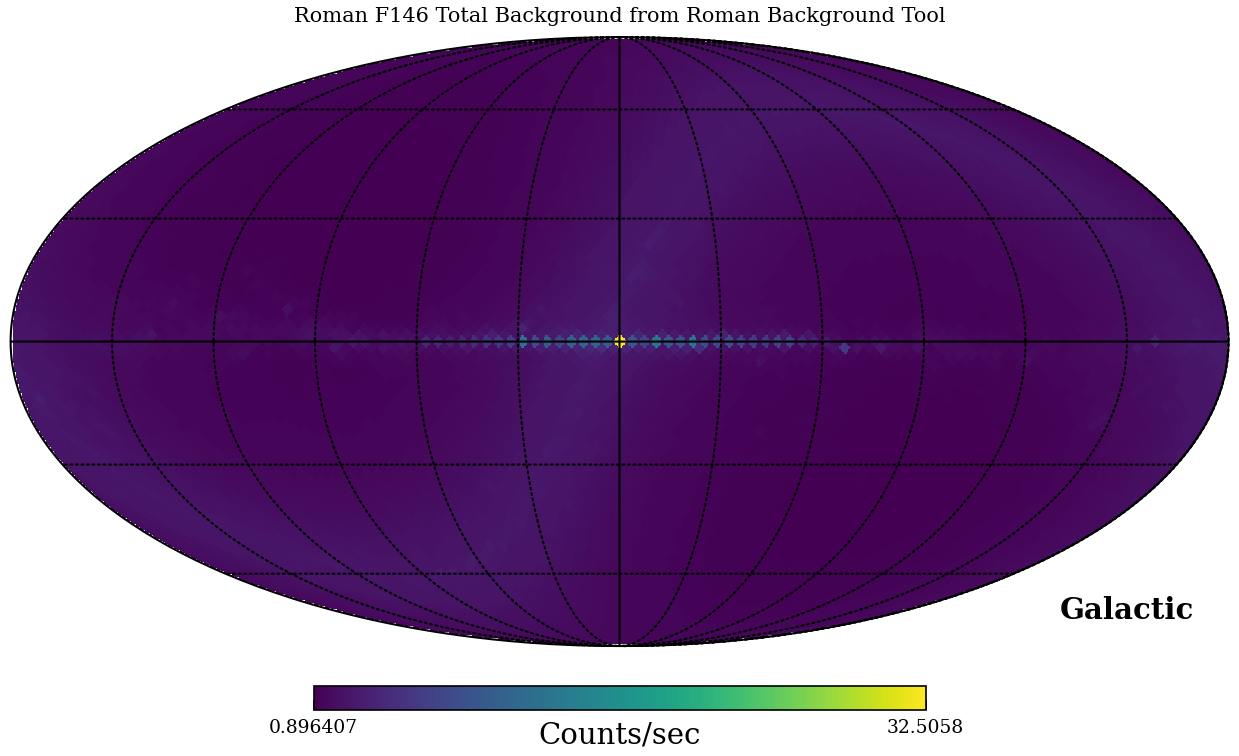

In [21]:
hp.mollview(cps_array, 
            title=r"Roman F146 Total Background from Roman Background Tool", 
            cmap='viridis', coord='G', unit=r'Counts/sec')
hp.graticule()
plt.savefig('total_bkg_roman_f146.png', dpi=300)
plt.show()

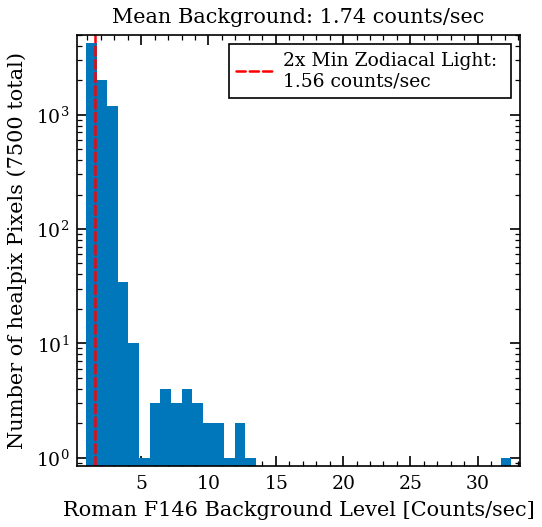

In [41]:
plt.hist(cps_array, bins=40, log=True)
plt.axvline(2 * min_zodi.value[0], color='red', linestyle='--', label=f'2x Min Zodiacal Light: \n{2 * min_zodi.value[0]:.2f} counts/sec')
plt.title(f'Mean Background: {np.mean(cps_array):.2f} counts/sec')
plt.xlabel('Roman F146 Background Level [Counts/sec]')
plt.ylabel('Number of healpix Pixels (7500 total)')
plt.legend()
plt.show()

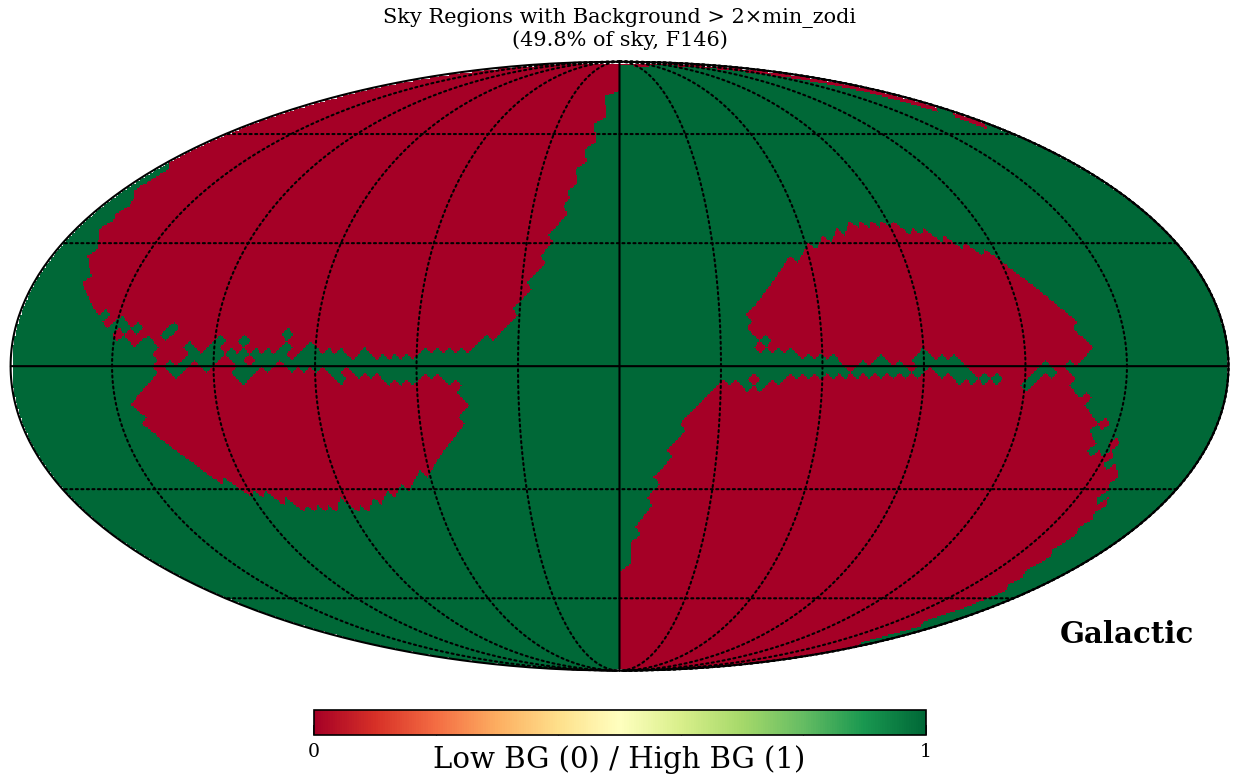

Sky fraction with background < 2×min_zodi: 49.81%
Threshold: 1.5620e+00 counts/sec


In [31]:
# Create binary mask for low background regions
threshold = 2 * min_zodi.value[0]
low_bg_mask = (cps_array > threshold).astype(float)
sky_frac = np.sum(low_bg_mask) / len(low_bg_mask) * 100

# Plot
hp.mollview(low_bg_mask, 
            title=f'Sky Regions with Background > 2×min_zodi\n({sky_frac:.1f}% of sky, F146)', 
            cmap='RdYlGn', coord='G', 
            unit='Low BG (0) / High BG (1)',
            cbar=True)
hp.graticule()
plt.savefig('low_background_fraction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Sky fraction with background < 2×min_zodi: {sky_frac:.2f}%")
print(f"Threshold: {threshold:.4e} counts/sec")

In [12]:
synthetic_images = []
for p in tqdm(input_pickles):
    synthetic_images.append(util.unpickle(p))
print(f'Loaded {len(synthetic_images)} synthetic image(s).')

100%|██████████| 612/612 [00:07<00:00, 78.45it/s] 

Loaded 612 synthetic image(s).


In [13]:
roman = Roman()
engine_params = GalSimEngine.defaults(roman.name)
pprint(engine_params)

{'dark_noise': True,
 'detector_effects': True,
 'ipc': True,
 'min_zodi_factor': 1.5,
 'nonlinearity': True,
 'poisson_noise': True,
 'read_noise': True,
 'reciprocity_failure': True,
 'sky_background': True}


In [14]:
print(f'Background CPS stats: mean={np.mean(cps_array):.2f}, min={np.min(cps_array):.2f}, max={np.max(cps_array):.2f}')
f146_min_sky_level = roman.get_minimum_zodiacal_light('F146')
print(f'F146 minimum sky level: {f146_min_sky_level} cps')

Background CPS stats: mean=1.89, min=0.90, max=32.51
F146 minimum sky level: [0.781] ct / pix cps


In [15]:
survey_area = 0.5
runs = 128
total_area = survey_area * runs

min_zodi_det_per_sq_deg = len(synthetic_images) / total_area
print(f'Detectable strong lenses per sq. deg.: {min_zodi_det_per_sq_deg:.2f}')

Detectable strong lenses per sq. deg.: 9.56


In [16]:
runs = 1
snr_threshold = 20

if dev:
    min_zodi_det_per_sq_deg /= 100
expected_num_per_pixel = min_zodi_det_per_sq_deg * pixel_area
rv = poisson(expected_num_per_pixel)
print(f'Expected number of detectable lenses per healpix pixel: {expected_num_per_pixel:.2f}')

Expected number of detectable lenses per healpix pixel: 13.15


In [17]:
progress_bar = False

detectable_counts = []
for cps in tqdm_auto(cps_array, desc='Background levels', disable=not progress_bar):

    detectable_trials = []
    for run in tqdm_auto(range(runs), desc='Runs', leave=False, disable=not progress_bar):

        num_detectable = 0

        # randomly draw the appropriate number of strong lenses for this healpix pixel
        num_lenses = rv.rvs()
        synth_images_for_pixel = np.random.choice(synthetic_images, size=num_lenses, replace=True)

        for img in tqdm_auto(synth_images_for_pixel, desc='Images', leave=False, disable=not progress_bar):
            engine_params['background_cps'] = cps

            exposure = Exposure(img,
                        exposure_time=30,
                        engine='galsim',
                        engine_params=engine_params,
                        verbose=False)
            
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                snr = exposure.get_snr()
            if snr >= snr_threshold:
                num_detectable += 1
        
        # calculate detectable fraction
        detectable_per_sq_deg = num_detectable / pixel_area
        detectable_trials.append(detectable_per_sq_deg)
    
    mean_detectable = np.mean(detectable_trials)
    detectable_counts.append(mean_detectable)

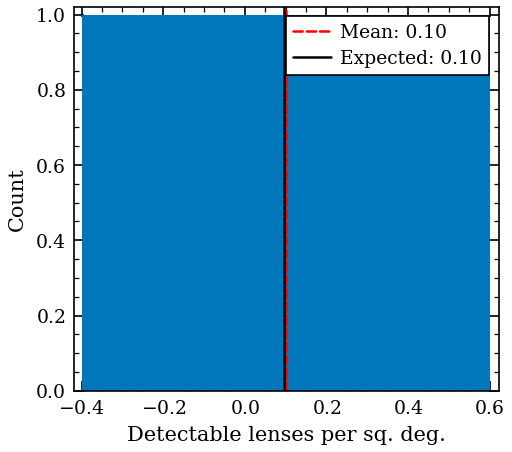

In [18]:
plt.figure(figsize=(3.4, 3))
plt.hist(detectable_trials)
plt.axvline(np.mean(detectable_trials), color='r', linestyle='--', label=f'Mean: {np.mean(detectable_trials):.2f}')
plt.axvline(min_zodi_det_per_sq_deg, color='k', linestyle='-', label=f'Expected: {min_zodi_det_per_sq_deg:.2f}')
plt.xlabel('Detectable lenses per sq. deg.')
plt.ylabel('Count')
plt.legend()
plt.savefig('detectable_lenses_hist.png', dpi=300)
plt.show()

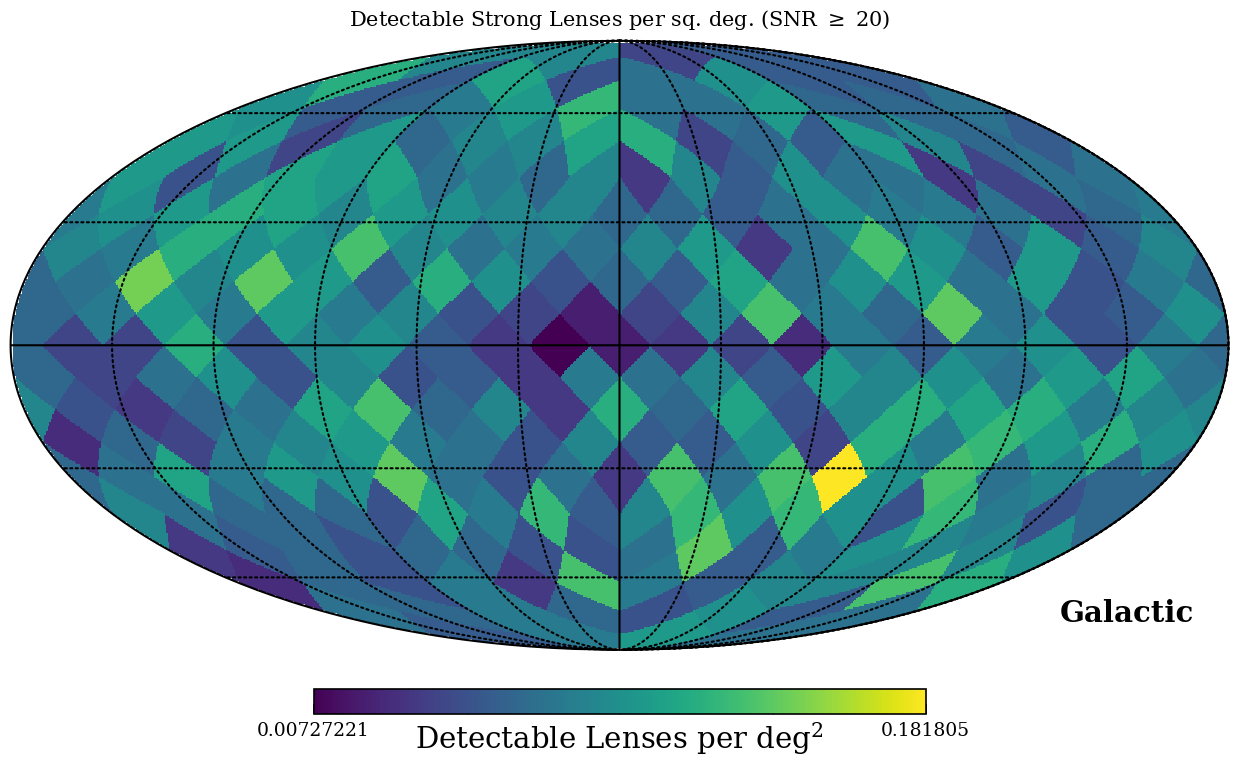

In [19]:
hp.mollview(np.array(detectable_counts), 
            title=f"Detectable Strong Lenses per sq. deg. (SNR $\geq$ {snr_threshold})", 
            cmap='viridis', coord='G', unit=r'Detectable Lenses per deg$^2$')
hp.graticule()
plt.savefig('nancy_detectable_sky_map.png', dpi=300)
plt.show()